In [1]:
#!pip install imblearn

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score,roc_auc_score, roc_curve

from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import time
from imblearn.metrics import classification_report_imbalanced

# moels
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatch
import warnings
warnings.filterwarnings('ignore')

In [3]:
sns.set_style('darkgrid')

In [4]:
data = pd.read_csv('data/creditcardcsv.zip', compression='zip')

In [5]:
data.shape

(284807, 31)

In [6]:
data.head(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


In [7]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


- we don't exactly know what the Vi features are but lets look at time and amount

Text(0.5, 1.0, 'Amount distribution')

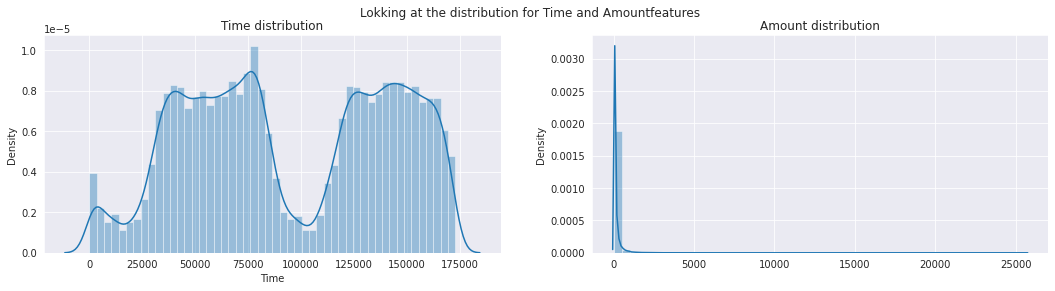

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(18, 4))
fig.suptitle("Lokking at the distribution for Time and Amountfeatures")
                        
sns.distplot(data['Time'], ax=axs[0])
axs[0].set_title("Time distribution")
sns.distplot(data['Amount'].values, ax=axs[1])
axs[1].set_title("Amount distribution")

In [9]:
data['Amount'].describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

<AxesSubplot:xlabel='Class', ylabel='Amount'>

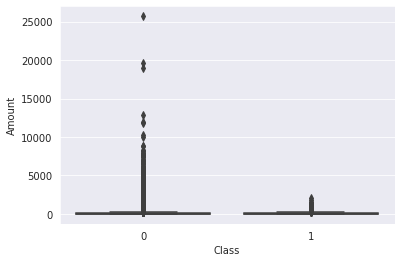

In [10]:
sns.boxplot(data['Class'], data['Amount'])

### Scaling the data

In [11]:
# seems like Amount needs to be scaled
scaler = StandardScaler()
data['Amount'] = scaler.fit_transform(data['Amount'].values.reshape(-1,1))
data['Amount'].describe()

count    2.848070e+05
mean     2.913952e-17
std      1.000002e+00
min     -3.532294e-01
25%     -3.308401e-01
50%     -2.652715e-01
75%     -4.471707e-02
max      1.023622e+02
Name: Amount, dtype: float64

In [12]:
# we drop the Time feature
data.drop('Time', axis=1, inplace=True)

### Is the data balanced

In [13]:
Counter(data['Class']) ## looks like the data is not balanced

Counter({0: 284315, 1: 492})

In [14]:
count = Counter(data['Class'])
total = data.shape[0]
fraud = (count[1] / total)*100
nonfraud = (count[0] / total)*100
print(f'Total number of observations are: {total}')
print(f'Fraud percecntage: {fraud}')
print(f'NonFraud percentage: {nonfraud}')


Total number of observations are: 284807
Fraud percecntage: 0.1727485630620034
NonFraud percentage: 99.82725143693798


### Are there NANs

In [15]:
data.isna().sum().any()

False

In [16]:
# since the data is not balanced, lets randomly pick 492 samples for the nonfraud cases
fraud_data = data[data['Class'] == 1]
nonfraud_data = data[data['Class'] == 0]
print(f"shape of fruad data is : {fraud_data.shape}, shape of non-fruad data is : {nonfraud_data.shape}")
nonfraud_data_subsample = nonfraud_data.sample(frac=fraud_data.shape[0]/nonfraud_data.shape[0], random_state=42)
print(f"shape of under sampled non-fraud data: {nonfraud_data_subsample.shape}")
balanced_data_random = pd.concat([fraud_data, nonfraud_data_subsample])
balanced_data_random = balanced_data_random.sample(frac=1, random_state=42)
print(f"the shape of balanced data after merging fraud and non-fraud data: {balanced_data_random.shape}")

shape of fruad data is : (492, 30), shape of non-fruad data is : (284315, 30)
shape of under sampled non-fraud data: (492, 30)
the shape of balanced data after merging fraud and non-fraud data: (984, 30)


 Amount has the highest std

<AxesSubplot:>

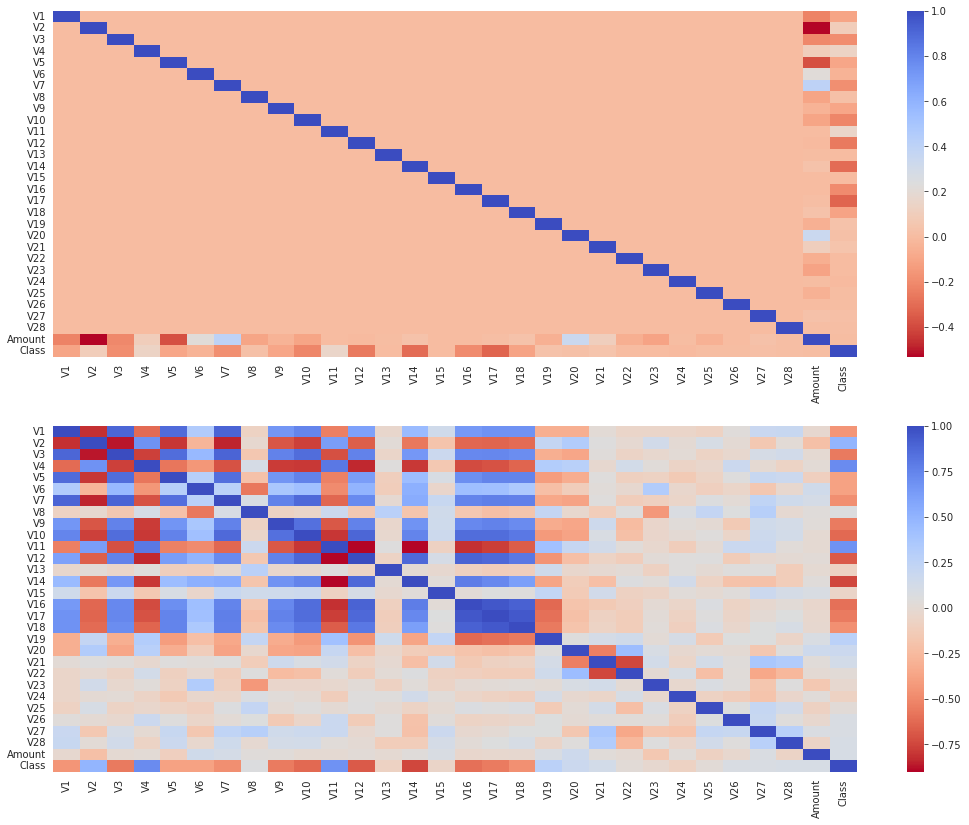

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 14))

corr = data.corr()
sns.heatmap(corr, ax=ax1, cmap='coolwarm_r')
balanced_corr = balanced_data_random.corr()
sns.heatmap(balanced_corr, ax=ax2, cmap='coolwarm_r')


### Looks like after balancing the data the corelation between the features are more visible
1. There are positive correlation between v2, v4, v11 and the class
2. There are negative correlation between v10, v12, v14 and the class
3. So it is better to be careful with the outliers in these feaures (I have not removed them in this notebook)

<AxesSubplot:xlabel='Class', ylabel='V14'>

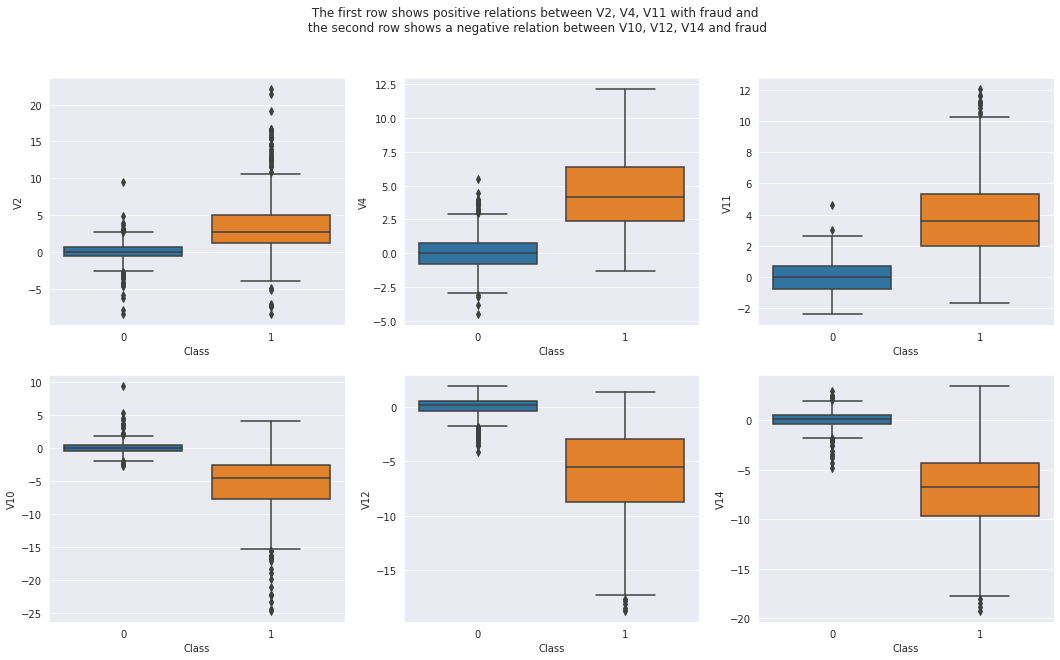

In [18]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle(" The first row shows positive relations between V2, V4, V11 with fraud and \n the second row shows a negative relation between V10, V12, V14 and fraud")

sns.boxplot(balanced_data_random['Class'], balanced_data_random['V2'], ax=ax1)
sns.boxplot(balanced_data_random['Class'], balanced_data_random['V4'], ax=ax2)
sns.boxplot(balanced_data_random['Class'], balanced_data_random['V11'], ax=ax3)

sns.boxplot(balanced_data_random['Class'], balanced_data_random['V10'], ax=ax4)
sns.boxplot(balanced_data_random['Class'], balanced_data_random['V12'], ax=ax5)
sns.boxplot(balanced_data_random['Class'], balanced_data_random['V14'], ax=ax6)

In [19]:
X_balanced_data_random = balanced_data_random.drop('Class', axis=1)
Y_balanced_data_random = balanced_data_random['Class']

### Using TSNE, PCA to visulize the cluster structure of the balanced data

In [20]:
tsne = TSNE(n_components=2)
t1 = time.time()
tsne_reduced = tsne.fit_transform(X_balanced_data_random)
t2 = time.time()
print(f"TSNE took: {t2 - t1}, and the reduced dimentions are: {tsne_reduced.shape}")


pca = PCA(n_components=2)
t1 = time.time()
pca_reduced = pca.fit_transform(X_balanced_data_random)
t2 = time.time()
print(f"PCA took: {t2 - t1}, and the reduced dimentions are: {pca_reduced.shape}")


TSNE took: 2.6471269130706787, and the reduced dimentions are: (984, 2)
PCA took: 0.027478456497192383, and the reduced dimentions are: (984, 2)


In [21]:
# converting the result to a dataframe
tsne_reduced_df = pd.DataFrame(tsne_reduced, columns=['tsne1', 'tsne2'])
tsne_reduced_df['Class'] = Y_balanced_data_random.values

pca_reduced_df = pd.DataFrame(pca_reduced, columns=['pca1', 'pca2'])
pca_reduced_df['Class'] = Y_balanced_data_random.values

In [22]:
pca_reduced_df.head()

,pca1,pca2,Class
0,-9.649964,0.958540,0
1,0.540383,-3.199987,1
2,-9.387030,0.900775,0
3,-0.871758,0.334166,1
4,17.647219,-6.016534,1


In [23]:
tsne_reduced_df.head()

,tsne1,tsne2,Class
0,43.737202,-4.998588,0
1,-42.020809,27.050980,1
2,17.318794,12.548180,0
3,-27.986746,8.876268,1
4,-51.919060,-1.926462,1


Text(0.5, 1.0, 'PCA')

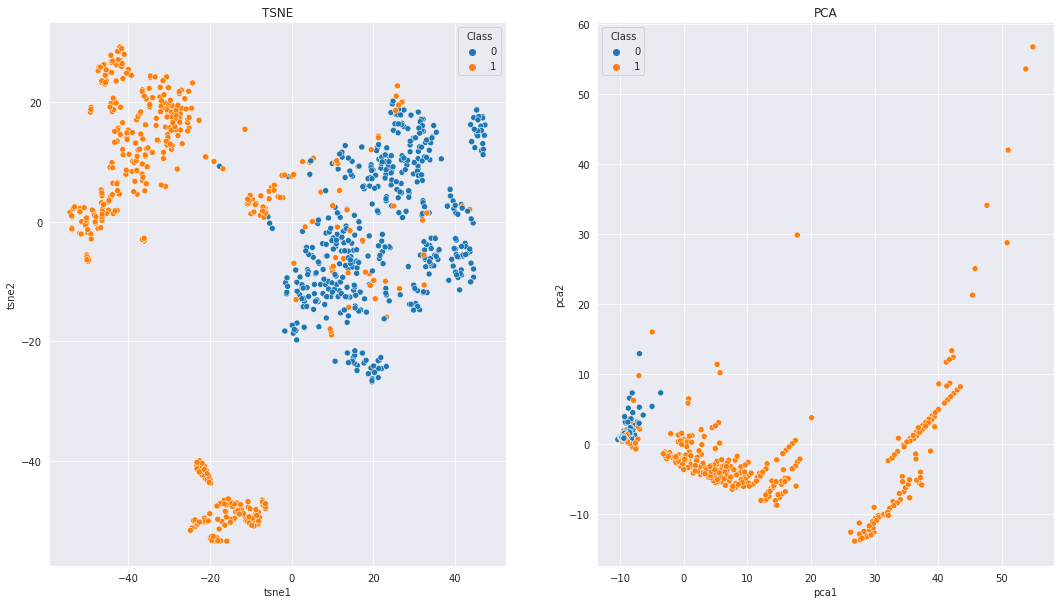

In [24]:
# blue_color = mpatch.Patch(color='#0000FA', label='no fraud')
# red_color = mpatch.Patch(color='#AF0000', label='fraud')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))
sns.scatterplot(tsne_reduced_df['tsne1'], tsne_reduced_df['tsne2'], ax=ax1, hue=tsne_reduced_df['Class'])
ax1.set_title('TSNE')

sns.scatterplot(pca_reduced_df['pca1'], pca_reduced_df['pca2'], ax=ax2, hue=pca_reduced_df['Class'])
ax2.set_title('PCA')

 # Model imbalanced data

In [25]:
classifiers = {
    'log_reg': LogisticRegression(),
    'svm': SVC(),
    'decisionTree': DecisionTreeClassifier()
}

 Before spliting the data, the shapes are 
 data is: (284807, 30), 
 x is: (284807, 29), 
 y is (284807,)
 Before spliting, the shapes are 
 x_train is: (199364, 29), 
 x_test is: (85443, 29),
 y_train is (199364,),
 y_test is (85443,)
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      0.87      1.00      0.93      0.88     85320
          1       0.67      0.87      1.00      0.76      0.93      0.86       123

avg / total       1.00      1.00      0.87      1.00      0.93      0.88     85443

roc_auc score for log_reg classifier is: 0.9346546144786342
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      0.94      1.00      0.97      0.95     85337
          1       0.63      0.94      1.00      0.75      0.97      0.94       106

avg / total       1.00      1.00      0.94      1.00      0.97      0.95     85443

roc_auc score for svm classifier i

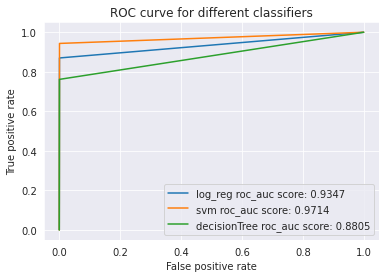

In [26]:
x = data.drop('Class', axis=1)
y = data['Class']
print(f" Before spliting the data, the shapes are \n data is: {data.shape}, \n x is: {x.shape}, \n y is {y.shape}")
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=30)
print(f" Before spliting, the shapes are \n x_train is: {x_train.shape}, \n x_test is: {x_test.shape},\n y_train is {y_train.shape},\n y_test is {y_test.shape}")

for name, clf in classifiers.items():
    clf.fit(x_train, y_train)
    preds = clf.predict(x_test)
    #print(classification_report(preds, y_test))
    print(classification_report_imbalanced(preds, y_test))
    roc_score = roc_auc_score(preds, y_test)
    print(f"roc_auc score for {name} classifier is: {roc_score}")
    fpr, tpr, threshold = roc_curve(preds, y_test)
    plt.plot(fpr, tpr, label=name + ' roc_auc score: {:.4f}'.format(roc_score))
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.legend()

plt.title('ROC curve for different classifiers')
plt.show()


 # Model data when it is balancesd using manual random under sampling 

 Before spliting the data, the shapes are:, 
 x is: (984, 29), 
 y is (984,)
 Before spliting, the shapes are 
 x_train is: (688, 29), 
 x_test is: (296, 29),
 y_train is (688,),
 y_test is (296,)
                   pre       rec       spe        f1       geo       iba       sup

          0       0.97      0.93      0.97      0.95      0.95      0.90       163
          1       0.92      0.97      0.93      0.95      0.95      0.91       133

avg / total       0.95      0.95      0.95      0.95      0.95      0.90       296

roc_auc score for log_reg classifier is: 0.951220074726694
                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.92      0.98      0.95      0.95      0.89       167
          1       0.90      0.98      0.92      0.94      0.95      0.90       129

avg / total       0.95      0.94      0.95      0.94      0.95      0.89       296

roc_auc score for svm classifier is: 0.9464559253585851
                  

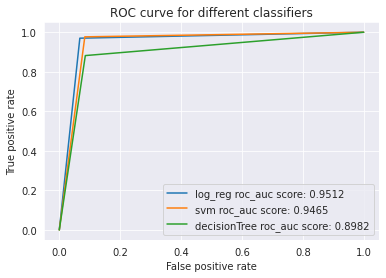

In [27]:
print(f" Before spliting the data, the shapes are:, \n x is: {X_balanced_data_random.shape}, \n y is {Y_balanced_data_random.shape}")
x_train, x_test, y_train, y_test = train_test_split(X_balanced_data_random, Y_balanced_data_random, test_size=0.3, random_state=30)
print(f" Before spliting, the shapes are \n x_train is: {x_train.shape}, \n x_test is: {x_test.shape},\n y_train is {y_train.shape},\n y_test is {y_test.shape}")

for name, clf in classifiers.items():
    clf.fit(x_train, y_train)
    preds = clf.predict(x_test)
    #print(classification_report(preds, y_test))
    print(classification_report_imbalanced(preds, y_test))
    roc_score = roc_auc_score(preds, y_test)
    print(f"roc_auc score for {name} classifier is: {roc_score}")
    fpr, tpr, threshold = roc_curve(preds, y_test)
    plt.plot(fpr, tpr, label=name + ' roc_auc score: {:.4f}'.format(roc_score))
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.legend()

plt.title('ROC curve for different classifiers')
plt.show()

### Looks like balancing the data has imporoved the models  

 # Model data when it is balancesd using undersampling via sklearn function RandomUnderSampling

 Before spliting the data, the shapes are:, 
 x is: (984, 29), 
 y is (984,)
 Before spliting, the shapes are 
 x_train is: (688, 29), 
 x_test is: (296, 29),
 y_train is (688,),
 y_test is (296,)
                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.89      0.98      0.93      0.93      0.86       157
          1       0.88      0.98      0.89      0.93      0.93      0.87       139

avg / total       0.93      0.93      0.93      0.93      0.93      0.87       296

roc_auc score for log_reg classifier is: 0.9318837923291942
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.86      0.99      0.92      0.92      0.84       164
          1       0.85      0.99      0.86      0.92      0.92      0.86       132

avg / total       0.93      0.92      0.93      0.92      0.92      0.85       296

roc_auc score for svm classifier is: 0.926090169992609
                  

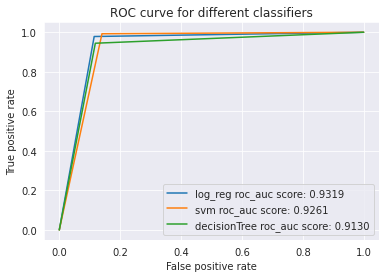

In [28]:
X = data.drop('Class', axis=1)
Y = data['Class']

rus = RandomUnderSampler()
X_balanced_data_rus, Y_balanced_data_rus = rus.fit_resample(X, Y)

print(f" Before spliting the data, the shapes are:, \n x is: {X_balanced_data_rus.shape}, \n y is {Y_balanced_data_rus.shape}")
x_train, x_test, y_train, y_test = train_test_split(X_balanced_data_rus, Y_balanced_data_rus, test_size=0.3, random_state=30)
print(f" Before spliting, the shapes are \n x_train is: {x_train.shape}, \n x_test is: {x_test.shape},\n y_train is {y_train.shape},\n y_test is {y_test.shape}")

for name, clf in classifiers.items():
    clf.fit(x_train, y_train)
    preds = clf.predict(x_test)
    #print(classification_report(preds, y_test))
    print(classification_report_imbalanced(preds, y_test))
    roc_score = roc_auc_score(preds, y_test)
    print(f"roc_auc score for {name} classifier is: {roc_score}")
    fpr, tpr, threshold = roc_curve(preds, y_test)
    plt.plot(fpr, tpr, label=name + ' roc_auc score: {:.4f}'.format(roc_score))
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.legend()

plt.title('ROC curve for different classifiers')
plt.show()

 # Model data when it is balancesd using undersampling via sklearn function NearMiss

 Before spliting the data, the shapes are:, 
 x is: (984, 29), 
 y is (984,)
 After spliting, the shapes are 
 x_train is: (688, 29), 
 x_test is: (296, 29),
 y_train is (688,),
 y_test is (296,)
                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.89      0.94      0.91      0.92      0.83       151
          1       0.89      0.94      0.89      0.92      0.92      0.84       145

avg / total       0.92      0.92      0.92      0.92      0.92      0.84       296

roc_auc score for log_reg classifier is: 0.9161224023749714
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.86      1.00      0.93      0.93      0.85       165
          1       0.85      1.00      0.86      0.92      0.93      0.87       131

avg / total       0.93      0.92      0.94      0.92      0.93      0.86       296

roc_auc score for svm classifier is: 0.9303030303030303
                  

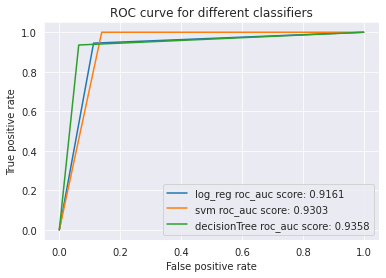

In [29]:
X = data.drop('Class', axis=1)
Y = data['Class']

nm = NearMiss()
X_balanced_data_nm, Y_balanced_data_nm = nm.fit_resample(X, Y)

print(f" Before spliting the data, the shapes are:, \n x is: {X_balanced_data_nm.shape}, \n y is {Y_balanced_data_nm.shape}")
x_train, x_test, y_train, y_test = train_test_split(X_balanced_data_nm, Y_balanced_data_nm, test_size=0.3, random_state=30)
print(f" After spliting, the shapes are \n x_train is: {x_train.shape}, \n x_test is: {x_test.shape},\n y_train is {y_train.shape},\n y_test is {y_test.shape}")

for name, clf in classifiers.items():
    clf.fit(x_train, y_train)
    preds = clf.predict(x_test)
    #print(classification_report(preds, y_test))
    print(classification_report_imbalanced(preds, y_test))
    roc_score = roc_auc_score(preds, y_test)
    print(f"roc_auc score for {name} classifier is: {roc_score}")
    fpr, tpr, threshold = roc_curve(preds, y_test)
    plt.plot(fpr, tpr, label=name + ' roc_auc score: {:.4f}'.format(roc_score))
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.legend()

plt.title('ROC curve for different classifiers')
plt.show()

 Before spliting the data, the shapes are:, 
 x is: (984, 29), 
 y is (984,)
 After spliting, the shapes are 
 x_train is: (688, 29), 
 x_test is: (296, 29),
 y_train is (688,),
 y_test is (296,)
                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.89      0.94      0.91      0.92      0.83       151
          1       0.89      0.94      0.89      0.92      0.92      0.84       145

avg / total       0.92      0.92      0.92      0.92      0.92      0.84       296

roc_auc score for log_reg classifier is: 0.9161224023749714
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.86      1.00      0.93      0.93      0.85       165
          1       0.85      1.00      0.86      0.92      0.93      0.87       131

avg / total       0.93      0.92      0.94      0.92      0.93      0.86       296

roc_auc score for svm classifier is: 0.9303030303030303
                  

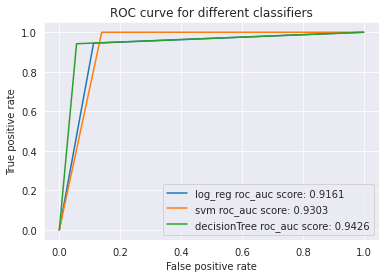

In [30]:
X = data.drop('Class', axis=1)
Y = data['Class']

nm = NearMiss(sampling_strategy='majority')
X_balanced_data_nm, Y_balanced_data_nm = nm.fit_resample(X, Y)

print(f" Before spliting the data, the shapes are:, \n x is: {X_balanced_data_nm.shape}, \n y is {Y_balanced_data_nm.shape}")
x_train, x_test, y_train, y_test = train_test_split(X_balanced_data_nm, Y_balanced_data_nm, test_size=0.3, random_state=30)
print(f" After spliting, the shapes are \n x_train is: {x_train.shape}, \n x_test is: {x_test.shape},\n y_train is {y_train.shape},\n y_test is {y_test.shape}")

for name, clf in classifiers.items():
    clf.fit(x_train, y_train)
    preds = clf.predict(x_test)
    #print(classification_report(preds, y_test))
    print(classification_report_imbalanced(preds, y_test))
    roc_score = roc_auc_score(preds, y_test)
    print(f"roc_auc score for {name} classifier is: {roc_score}")
    fpr, tpr, threshold = roc_curve(preds, y_test)
    plt.plot(fpr, tpr, label=name + ' roc_auc score: {:.4f}'.format(roc_score))
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.legend()

plt.title('ROC curve for different classifiers')
plt.show()

 # Model data when it is balancesd using oversampling via sklearn function SMOTE
 - For this because we are going to over sample, we should split for test before oversampling

 Before spliting the data, the shapes are:, 
 x is: (984, 29), 
 y is (984,)
 After spliting, the shapes are 
 x_train is: (688, 29), 
 x_test is: (296, 29),
 y_train is (688,),
 y_test is (296,)
Before smote train, test classes are: Counter({1: 350, 0: 338}) Counter({0: 154, 1: 142})
Before smote and after merging train, test classes are: Counter({0: 284160, 1: 350}) Counter({0: 154, 1: 142})
 after SMOTE over sampling, the shapes are 
 x_train_smote is: (568320, 29), 
 x_test is: (296, 29),
 y_train_smote is (568320,),
 y_test is (296,)
After smote train, test classes are: Counter({1: 284160, 0: 284160}) Counter({0: 154, 1: 142})
                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.92      0.93      0.93      0.93      0.86       158
          1       0.91      0.93      0.92      0.92      0.93      0.86       138

avg / total       0.93      0.93      0.93      0.93      0.93      0.86       296

roc_auc score for log_reg

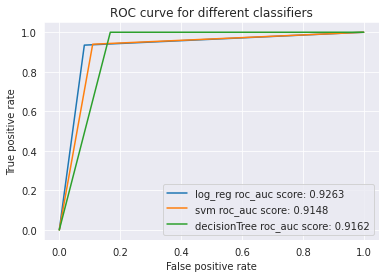

In [31]:
frauds = data[data['Class']==1]
nonFrauds = data[data['Class']==0]
nonFrauds_sub = nonFrauds[:492]

concatinated = pd.concat([frauds, nonFrauds_sub])
x = concatinated.drop('Class', axis=1)
y = concatinated['Class']

print(f" Before spliting the data, the shapes are:, \n x is: {x.shape}, \n y is {y.shape}")
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=30)
print(f" After spliting, the shapes are \n x_train is: {x_train.shape}, \n x_test is: {x_test.shape},\n y_train is {y_train.shape},\n y_test is {y_test.shape}")
print("Before smote train, test classes are:", Counter(y_train), Counter(y_test))

trainAndRem = x_train
trainAndRem['Class'] = y_train
unbalanced_train = pd.concat([trainAndRem, nonFrauds[493:]])
unbalanced_train_x = unbalanced_train.drop('Class', axis=1)
unbalanced_train_y = unbalanced_train['Class']
print("Before smote and after merging train, test classes are:", Counter(unbalanced_train_y), Counter(y_test))

smote = SMOTE()
x_train_smote, y_train_smote = smote.fit_resample(unbalanced_train_x, unbalanced_train_y)
print(f" after SMOTE over sampling, the shapes are \n x_train_smote is: {x_train_smote.shape}, \n x_test is: {x_test.shape},\n y_train_smote is {y_train_smote.shape},\n y_test is {y_test.shape}")
print("After smote train, test classes are:", Counter(y_train_smote), Counter(y_test))

for name, clf in classifiers.items():
    clf.fit(x_train_smote, y_train_smote)
    preds = clf.predict(x_test)
    #print(classification_report(preds, y_test))
    print(classification_report_imbalanced(preds, y_test))
    roc_score = roc_auc_score(preds, y_test)
    print(f"roc_auc score for {name} classifier is: {roc_score}")
    fpr, tpr, threshold = roc_curve(preds, y_test)
    plt.plot(fpr, tpr, label=name + ' roc_auc score: {:.4f}'.format(roc_score))
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.legend()

plt.title('ROC curve for different classifiers')
plt.show()

In [32]:
# import matplotlib.patches as mpatches
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE

# blue_patch = mpatches.Patch(color='#0A0AFF', label='no fraud')
# red_patch = mpatches.Patch(color='#AF0000', label='fraud')



# tsne = TSNE(n_components=2, random_state=42)
# X_reduced_tsne = tsne.fit_transform(x_under_sample)
# X_reduced_tsne.shape

# fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# ax.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y_under_sample==0), label='no fraud', cmap='coolwarm')
# ax.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y_under_sample==1), label='fraud', cmap='coolwarm')
# ax.set_title('TSNE')
# ax.legend(handles=[blue_patch, red_patch])